In [126]:
# import pandas and gurobi
import pandas as pd
from gurobipy import *
import numpy as np


In [137]:
# read in csv
r = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_returns_2019.csv")
s = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/sectors_2019.csv")
p = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_prices_2019.csv")
cor = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/corr_2019.csv")
cov = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/cov_2019.csv")
vol = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_volume_2019.csv")
cov = cov.drop(columns=['Unnamed: 0'])
s = s.drop(columns=['Symbol'])
p = p.drop(columns=['Date'])
r = r.drop(columns=['Date'])
cor = cor.drop(columns=['Unnamed: 0'])
vol = vol.drop(columns=['Date'])
# cast vol to float
vol = vol.astype(float)

In [136]:
# make model
stocks = len(s)
k = 10
T = 12
transaction = np.zeros(T)
# total = array of size 12
total = np.zeros(T+1)
total[0] = 100000
portfolio = np.zeros((stocks, T))
inventoryT0 = np.zeros((stocks))
inventoryT1 = np.zeros((stocks))
obj = np.zeros(T+1)
obj2 = np.zeros(T+1)

for t in range(T): 
    m = Model('portfolio')

    # Add matrix variable for the stocks
    x = m.addMVar(stocks, lb = 0, ub = .5) 
    z = m.addVars(stocks, vtype=GRB.BINARY, name="z")
    b = m.addVars(stocks, vtype=GRB.INTEGER, lb=0, name="x")

    # Objective is to minimize risk (squared).  This is modeled using the
    # covariance matrix, which measures the historical correlation between stocks
    portfolio_risk = x @ np.matrix(cov) @ x
    ret = np.matrix(r.iloc[t]) @ x
    m.setObjective(ret, GRB.MAXIMIZE)

    # Fix budget with a constraint
    m.addConstr(x.sum() == 1, 'budget')
    # return is at least 0.1
    m.addConstr(portfolio_risk <= 0.05, 'return')
    m.addConstrs((x[i] <= z[i] for i in range(stocks)), "w<=z")
    #m.addConstrs((b[i] >= z[i]*5 for i in range(stocks)), "b<=5")
    m.addConstrs((10000*x[i] >= z[i] for i in range(stocks)), "w>=z")
    m.addConstr(quicksum(z[i] for i in range(stocks)) >= k, "k")
    m.addConstr(quicksum(b[i]*p.iloc[t,i] for i in range(stocks)) <= total[t], "budget")
    m.addConstrs((b[i] >= z[i] for i in range(stocks)), "x>=fvfav")
    m.addConstrs((x[i] == (b[i]*p.iloc[t,i])/(total[t]) for i in range(stocks)), "w")
    m.addConstrs((quicksum(z[i]*s.iloc[i,j] for i in range(stocks)) <= 4 for j in range(len(s.columns))), "sector")
    # difference between b[i] and inventoryT1[i] is less than v[i,t]
    m.addConstrs((b[i] - inventoryT1[i] <= .05*vol.iloc[t,i] for i in range(stocks)), "v")
    m.Params.MIPGap = 0.01

    # stocks we buy must have a corr[i,j] < 0.5
    m.addConstrs((z[i] + z[j] <= 1 for i in range(stocks) for j in range(stocks) if i != j and cor.iloc[i,j] > 0.3), "corr")

    m.optimize()
    
    obj[t] = portfolio_risk.getValue()
    obj2[t] = ret.getValue()
    if t == 0:
       #make inventoryT0 equal to all zeros
        inventoryT0 = np.zeros((stocks))
    else:
        inventoryT0 = inventoryT1.copy()
    # print optimal x
    for v in m.getVars():
        if v.varName[0] == 'x':
            inventoryT1[int(v.varName.replace("x[","").replace("]",""))] = v.x
            total[t+1] += v.x*p.iloc[t+1,int(v.varName.replace("x[","").replace("]",""))]
            if (abs(inventoryT0[int(v.varName.replace("x[","").replace("]",""))]-inventoryT1[int(v.varName.replace("x[","").replace("]",""))])) > 0:
                total[t+1] -= (8.9)
                transaction[t] += 1
                # avg transaction cost
            
    portfolio[:,t] = np.array([v.x for v in m.getVars() if v.varName[0] == 'C'])
    

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 116703 rows, 1431 columns and 234809 nonzeros
Model fingerprint: 0x7a149b7b
Model has 1 quadratic constraint
Variable types: 477 continuous, 954 integer (477 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+04]
  QMatrix range    [1e-08, 1e-01]
  Objective range  [6e-04, 3e-01]
  Bounds range     [5e-01, 1e+00]
  RHS range        [1e+00, 7e+06]
  QRHS range       [5e-02, 5e-02]
Presolve removed 112183 rows and 2 columns
Presolve time: 1.63s
Presolved: 4520 rows, 1429 columns, 110253 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 475 continuous, 954 integer (477 binary)

Root relaxation: objective 7.252154e-02, 1872 iterations, 0.19 seconds (0.56 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dept

In [138]:
#loop through total and print out the total value of the portfolio at each time step
for i in range(len(total)):
    if i == 0:
        print("Initial value: " + str(total[i]))
    else:
        print("Total value of portfolio at the end of month " + ": " + str(total[i]), " Risk: " + str(obj[i]), " Return: " + str(obj2[i]))

Initial value: 100000.0
Total value of portfolio at the end of month : 115113.21025276186  Risk: 0.022949896701796053  Return: 0.43445821207938096
Total value of portfolio at the end of month : 133262.07164154062  Risk: 0.019858885749805343  Return: 0.2906319961193227
Total value of portfolio at the end of month : 141111.010242653  Risk: 0.0041023727055306625  Return: 0.18785349378667096
Total value of portfolio at the end of month : 151381.9726474763  Risk: 0.01275405997221184  Return: 0.33497894188506594
Total value of portfolio at the end of month : 128039.27776460654  Risk: 0.022327142250856424  Return: 0.31504421589188136
Total value of portfolio at the end of month : 134948.84339294437  Risk: 0.034340189592372165  Return: 0.30076012106136873
Total value of portfolio at the end of month : 126367.63290252697  Risk: 0.019036276601571357  Return: 0.3530902562507782
Total value of portfolio at the end of month : 126505.69119625095  Risk: 0.00543343804433955  Return: 0.2142600814572123

In [130]:
# mean of r over rows
(total[-1]-100000)/100000

0.5174214293613433

In [148]:
r

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
0,-0.087277,-0.111157,-0.026121,-0.015695,-0.053603,-0.154718,-0.000644,-0.125320,-0.113688,-0.105445,...,-0.053826,-0.109808,-0.174305,-0.062133,-0.077178,-0.001629,-0.122071,-0.107140,-0.158091,-0.085818
1,0.051223,0.126019,0.013665,-0.118399,0.080082,0.088930,0.014387,0.095924,0.095385,0.066504,...,0.071974,0.046147,0.243656,0.062716,0.068046,0.022411,0.090247,0.056305,0.168139,0.009237
2,0.042555,0.085040,0.063579,-0.013078,-0.047199,0.050993,-0.107959,-0.045544,0.059237,0.094322,...,0.056699,0.036406,0.034781,0.047746,0.063704,0.010043,0.155011,0.132895,0.080251,0.093663
3,0.001880,0.026767,0.029889,0.017037,-0.146218,0.090718,0.089125,0.014823,0.015200,0.049282,...,0.024870,-0.012600,-0.057057,0.031986,0.046194,0.056190,0.044985,0.030793,-0.111350,0.068343
4,-0.087930,-0.010171,-0.000680,-0.001829,-0.028642,0.046375,0.058862,0.034083,0.085407,0.029110,...,0.049473,-0.062905,0.210610,0.005159,0.055162,0.045887,0.007684,-0.035552,0.086324,0.013298
5,-0.149824,-0.229599,-0.043112,-0.033757,-0.055838,-0.025182,-0.100394,-0.133353,-0.063440,-0.025975,...,-0.047955,-0.067108,-0.250740,0.014867,-0.107186,-0.015435,-0.188027,-0.074943,-0.121223,-0.007757
6,0.085070,0.164444,0.104689,-0.052014,-0.005460,0.037626,0.088310,0.064718,0.087671,0.037499,...,0.095206,0.024991,0.155222,0.044604,0.126920,0.081290,0.221944,0.035611,0.067564,0.123107
7,0.007961,-0.031397,0.039550,-0.069914,0.069369,0.042269,0.032627,0.006863,0.014288,0.007198,...,0.019213,0.085002,0.049036,0.002017,-0.040053,0.016716,0.006683,0.147698,-0.019791,0.013799
8,-0.065935,0.023542,-0.020436,-0.013209,-0.306900,0.029027,0.038162,-0.065028,-0.048016,0.019937,...,0.014087,-0.054800,-0.144953,0.077336,-0.042741,0.041618,-0.027787,0.030119,-0.080728,0.100357
9,0.016572,0.025580,-0.019339,0.151810,-0.078624,-0.029369,0.045850,0.079369,-0.029032,-0.044894,...,-0.022046,0.085876,-0.012982,0.016945,0.039290,-0.028686,0.006536,-0.012132,0.083475,-0.014476


In [153]:
(.5174-0.334956)/.334956

0.5446804953486428

In [151]:
np.cumprod(1+r.iloc[1:,:].mean(axis=1))-1

1     0.096632
2     0.142512
3     0.156021
4     0.200642
5     0.129528
6     0.217518
7     0.233232
8     0.206635
9     0.239369
10    0.256155
11    0.301491
12    0.334956
dtype: float64

In [152]:
import plotly.graph_objects as go

result_returns = np.zeros(T+1)
for i in range(1,len(total)):
    result_returns[i] = (total[i]-total[i-1])/total[i-1]
# graph in plotly - plt.plot(np.cumprod(1+result_returns)-1)
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0,T+1), y=np.cumprod(1+result_returns[1:])-1, name='Portfolio'))
fig.add_trace(go.Scatter(x=np.arange(0,T+1), y=np.cumprod(1+r.iloc[1:,:].mean(axis=1))-1, name='S&P 500'))
# labels
fig.update_layout(title='Our Portfolio\'s Returns compared to S&P 500', xaxis_title='Month', yaxis_title='Returns')
fig.show()

In [139]:
# ploty transactions over time
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0,T), y=transaction, name='Transactions'))
# labels
fig.update_layout(title='Transactions over Time', xaxis_title='Month', yaxis_title='Transactions')
fig.show()

Text(0, 0.5, 'Percentage of portfolio')

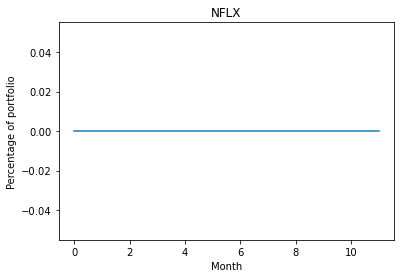

In [131]:
import matplotlib.pyplot as plt
stockPlot = r.columns.get_loc("NFLX")
plt.plot(portfolio[stockPlot,:])
# TITLE  = stock name
plt.title(p.columns[stockPlot])
plt.xlabel("Month")
plt.ylabel("Percentage of portfolio")

In [97]:
# graph every stock in portfolio on same graph in plotly
import plotly.graph_objects as go
fig = go.Figure()
for i in range(len(portfolio)):
    fig.add_trace(go.Scatter(x=np.arange(0,12), y=portfolio[i,:], name=p.columns[i]))
fig.show()
